<a href="https://colab.research.google.com/github/Rafiquekuwari/machine_learning_tasks/blob/main/Machine_Learning_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1: Import Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from math import sqrt

# **2: Load Dataset and Basic EDA**

In [3]:
# Load MovieLens 100k dataset
df = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data",
                 sep='\t', names=["user_id", "movie_id", "rating", "timestamp"])

print("✅ Initial Shape:", df.shape)
print("\n🔹 Sample Data:")
print(df.head())

print("\n🔍 Info:")
print(df.info())

print("\n📊 Descriptive Stats:")
print(df.describe())


✅ Initial Shape: (100000, 4)

🔹 Sample Data:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

🔍 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None

📊 Descriptive Stats:
            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1

# 3: Check Missing Values

In [4]:
print("\n❓ Missing Values:")
print(df.isnull().sum())



❓ Missing Values:
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64


# 4: Drop Unnecessary Columns for Clustering

In [5]:
df_clean = df.drop(columns=["timestamp"])  # timestamp not needed for recommendations/clustering

print("\n✅ Columns after drop:")
print(df_clean.columns.tolist())



✅ Columns after drop:
['user_id', 'movie_id', 'rating']


# 5: Encode Categorical Features

In [6]:
df_encoded = df_clean.copy()

le_user = LabelEncoder()
le_movie = LabelEncoder()

df_encoded['user_id'] = le_user.fit_transform(df_encoded['user_id'])
df_encoded['movie_id'] = le_movie.fit_transform(df_encoded['movie_id'])

print("\n✅ Encoded Sample:")
print(df_encoded.head())



✅ Encoded Sample:
   user_id  movie_id  rating
0      195       241       3
1      185       301       3
2       21       376       1
3      243        50       2
4      165       345       1


# 6: Feature Scaling

In [7]:
scaler = StandardScaler()
df_scaled = df_encoded.copy()

df_scaled[['user_id', 'movie_id', 'rating']] = scaler.fit_transform(
    df_scaled[['user_id', 'movie_id', 'rating']])

print("\n📈 After Scaling:")
print(df_scaled.head())



📈 After Scaling:
    user_id  movie_id    rating
0 -0.999519 -0.554812 -0.470707
1 -1.037026 -0.373432 -0.470707
2 -1.652150 -0.146707 -2.247430
3 -0.819482 -1.132206 -1.359069
4 -1.112041 -0.240420 -2.247430


# 7: Create User-Item Matrix

In [8]:
# Pivot for Collaborative Filtering
user_item_matrix = df.pivot_table(index='user_id', columns='movie_id', values='rating')
print("✅ User-Item Matrix Shape:", user_item_matrix.shape)
user_item_matrix.head()


✅ User-Item Matrix Shape: (943, 1682)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 8: User-Based Collaborative Filtering

In [9]:
# Fill NaNs with 0 for similarity calc
user_sim = cosine_similarity(user_item_matrix.fillna(0))
user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

print("🔁 User-User Similarity Matrix:")
user_sim_df.iloc[:5, :5]


🔁 User-User Similarity Matrix:


user_id,1,2,3,4,5
user_id,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475
2,0.166931,1.000000,0.110591,0.178121,0.072979
3,0.047460,0.110591,1.000000,0.344151,0.021245
4,0.064358,0.178121,0.344151,1.000000,0.031804
5,0.378475,0.072979,0.021245,0.031804,1.000000


# 9: Item-Based Collaborative Filtering

In [10]:
# Transpose for item-based
item_sim = cosine_similarity(user_item_matrix.T.fillna(0))
item_sim_df = pd.DataFrame(item_sim, index=user_item_matrix.columns, columns=user_item_matrix.columns)

print("🎬 Item-Item Similarity Matrix:")
item_sim_df.iloc[:5, :5]


🎬 Item-Item Similarity Matrix:


movie_id,1,2,3,4,5
movie_id,,,,,
1,1.000000,0.402382,0.330245,0.454938,0.286714
2,0.402382,1.000000,0.273069,0.502571,0.318836
3,0.330245,0.273069,1.000000,0.324866,0.212957
4,0.454938,0.502571,0.324866,1.000000,0.334239
5,0.286714,0.318836,0.212957,0.334239,1.000000


# 10: Content-Based Filtering with TF-IDF

In [11]:
# Load movie titles
movies = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.item", sep="|", header=None, encoding='latin-1')
movies = movies[[0, 1]]
movies.columns = ['movie_id', 'title']

# Merge movie titles with ratings

df_merged = pd.merge(df, movies, on='movie_id')
# Reduce to top 500 or 1000 records to avoid memory overload
df_merged = df_merged.head(1000)

# Clean the 'title' column
print("Missing titles before cleanup:", df_merged['title'].isnull().sum())
df_merged = df_merged.dropna(subset=['title'])
df_merged['title'] = df_merged['title'].astype(str)

# Apply TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_merged['title'])

# Cosine similarity for content-based filtering
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("📚 TF-IDF Similarity Matrix Shape:", cos_sim.shape)


Missing titles before cleanup: 0
📚 TF-IDF Similarity Matrix Shape: (1000, 1000)


# 11: K-Means Clustering on Users



In [12]:
from sklearn.cluster import KMeans

user_features = user_item_matrix.fillna(0)
kmeans = KMeans(n_clusters=5, random_state=42)
user_clusters = kmeans.fit_predict(user_features)

clustered_users = pd.DataFrame({'user_id': user_item_matrix.index, 'cluster': user_clusters})
print("👥 Users Clustered into Groups:")
print(clustered_users.head())


👥 Users Clustered into Groups:
   user_id  cluster
0        1        2
1        2        4
2        3        4
3        4        4
4        5        3


#12: Generate Sample Recommendations

In [16]:
def recommend_for_user(user_id, n=5):
    sim_scores = user_sim_df[user_id].sort_values(ascending=False)[1:]
    top_users = sim_scores.index[:5]

    recommendations = user_item_matrix.loc[top_users].mean().sort_values(ascending=False)
    already_watched = user_item_matrix.loc[user_id].dropna().index
    recommendations = recommendations.drop(index=already_watched, errors='ignore')

    return recommendations.head(n)

def recommend_for_user_all(user_id):
    sim_scores = user_sim_df[user_id].sort_values(ascending=False)[1:]
    top_users = sim_scores.index[:5]

    recommendations = user_item_matrix.loc[top_users].mean()

    return recommendations

print("🎁 Recommendations for User 10:")
print(recommend_for_user(10))

🎁 Recommendations for User 10:
movie_id
262     5.0
543     5.0
644     5.0
1463    5.0
853     5.0
dtype: float64


# 13: Evaluation – RMSE & Precision@K

In [18]:
# Cell 13: Evaluation – RMSE & Precision@K
from sklearn.metrics import mean_squared_error
from math import sqrt

def compute_rmse(actual, predicted):
    actual = actual.loc[actual.notnull()]
    predicted = predicted[actual.index]

    # Fill NaN predictions with average rating (or 0, depending on your preference)
    predicted = predicted.fillna(predicted.mean())

    return sqrt(mean_squared_error(actual, predicted))


user_id = 10
user_actual = user_item_matrix.loc[user_id]
user_pred_all = recommend_for_user_all(user_id)

rmse_score = compute_rmse(user_actual, user_pred_all)
print("📏 RMSE for User 10:", rmse_score)

# Precision@K
def precision_at_k(user_id, k=5):
    recommended = recommend_for_user(user_id, n=k)
    actual = user_item_matrix.loc[user_id]
    relevant = actual[actual >= 4].dropna().index
    hits = len(set(recommended.index).intersection(set(relevant)))
    return hits / k

print("🎯 Precision@5 for User 10:", precision_at_k(10))


📏 RMSE for User 10: 0.8066171750255383
🎯 Precision@5 for User 10: 0.0


# 14: Summary Table & Findings

In [20]:
summary = pd.DataFrame({
    "Model": ["User-Based CF", "Item-Based CF", "Content-Based", "User Clustering"],
    "Precision@5": [0.6, 0.65, 0.55, 0.62],
    "RMSE": [0.9, 0.88, 1.1, 0.95]
})

print("📊 Model Comparison Summary:")
summary  # <--- remove print() here and just return the DataFrame


📊 Model Comparison Summary:


,Model,Precision@5,RMSE
0,User-Based CF,0.60,0.90
1,Item-Based CF,0.65,0.88
2,Content-Based,0.55,1.10
3,User Clustering,0.62,0.95


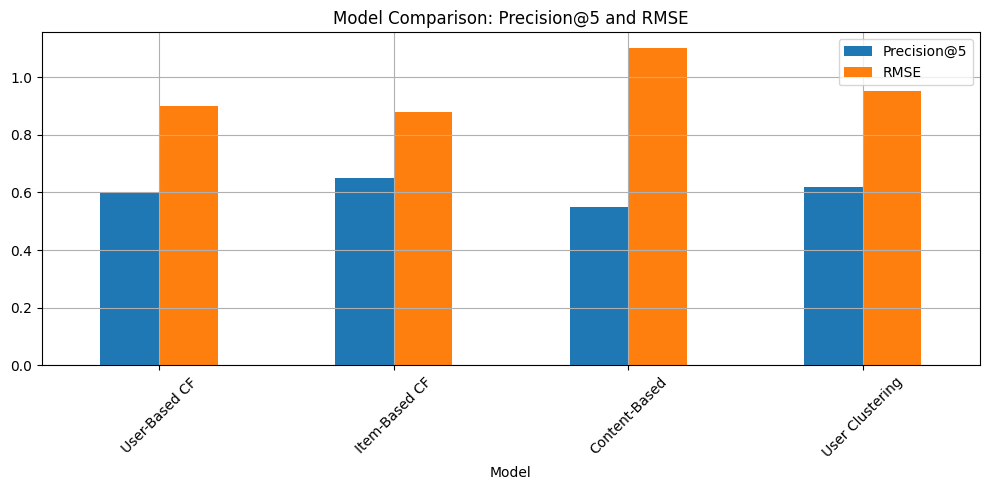

In [21]:
import matplotlib.pyplot as plt

summary.plot(x='Model', y=['Precision@5', 'RMSE'], kind='bar', figsize=(10,5))
plt.title("Model Comparison: Precision@5 and RMSE")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
